# Preliminary operations

We import libraries and datasets.

In [1]:
# Utility
from google.colab import drive
from shutil import copyfile
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import subprocess
import tkinter as tk
import random

# Image processing
import cv2
from PIL import Image

# KDTree
from sklearn.neighbors import KDTree
import joblib

# Keras
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading the tree.

In [3]:
tree = joblib.load('/content/gdrive/MyDrive/Digital Signal/Models/Image Retrieval/mob_tree.joblib')

Loading the MobileNetV2.

In [ ]:
mobilenet = keras.applications.MobileNetV2(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False, pooling = 'max')

Loading the dataframes for computing accuracy.

In [5]:
df_actors = pd.read_csv('/content/gdrive/MyDrive/Digital Signal/Dataset/list_attr_actors.csv')
df_celeba = pd.read_csv('/content/gdrive/MyDrive/Digital Signal/Dataset/list_attr_celeba.csv')

Unzipping the celebrities images.

In [6]:
!mkdir '/content/celeb'

In [ ]:
copyfile('/content/gdrive/MyDrive/Digital Signal/Dataset/celeba.zip', 'celeba.zip')

In [ ]:
!unzip 'celeba.zip' -d '/content/celeb'

# Acquisition

In [ ]:
root= tk.Tk()

canvas1 = tk.Canvas(root, width=400, height=300, relief='raised')
canvas1.pack()

label1 = tk.Label(root, text='Select clip to analize')
label1.config(font=('helvetica', 16))
canvas1.create_window(200, 25, window=label1)

label2 = tk.Label(root, text='Number from 0 to 6:')
label2.config(font=('helvetica', 11))
canvas1.create_window(200, 100, window=label2)

def display_text():
   global example
   example = int(example.get())
   root.destroy

example = tk.Entry(root)
example.pack()
canvas1.create_window(200, 140, window=example)

    
button1 = tk.Button(text='Select', command=lambda: [display_text(), root.destroy()], font=('helvetica', 12, 'bold'))
canvas1.create_window(200, 180, window=button1)

root.mainloop()

In [122]:
example = int('00')
fn = os.listdir('/content/gdrive/MyDrive/Digital Signal/Dataset/Actor_faces/')
fn.sort()
actor_path = '/content/gdrive/MyDrive/Digital Signal/Dataset/Actor_faces/' + fn[example]

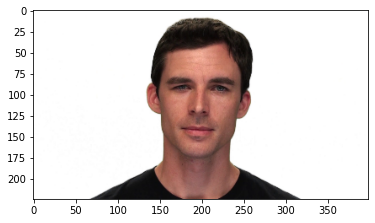

In [123]:
im = Image.open(actor_path)
plt.imshow(im)

In [ ]:
#player = subprocess.call([path per lettore immagini, actor_path, '--play-and-exit'])

# Processing

In order to crop the background as much as possible, we use a Haar cascade classifier to detect and crop faces.

In [124]:
# Load the cascade classifier
face_cascade = cv2.CascadeClassifier('/content/gdrive/MyDrive/Digital Signal/Dataset/haarcascade_frontalface_default.xml')

def crop_face(path, scaleFactor, minNeighbors):
  # Read the input image
  im = cv2.imread(path)
  # Convert the image to grayscale
  gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  # Detect faces in the image
  faces = face_cascade.detectMultiScale(gray, scaleFactor, minNeighbors)
  if len(faces) == 0:
    # We may try to decrease the scaleFactor parameter
    faces = face_cascade.detectMultiScale(gray, scaleFactor - 0.1, minNeighbors)
    if len(faces) == 0:
      return (0, 0)
    elif len(faces) > 1:
      return (1, 0)
    else:
      # Draw rectangles around the faces
      for (x, y, w, h) in faces:
        face = im[y:y+h, x:x+w]
        face = cv2.resize(face, (224, 224))
        return (2, face)
  elif len(faces) > 1:
    # We may try to increase the scaleFactor parameter
    faces = face_cascade.detectMultiScale(gray, scaleFactor + 0.1, minNeighbors)
    if len(faces) == 0:
      return (0, 0)
    elif len(faces) > 1:
      return (1, 0)
    else:
      # Draw rectangles around the faces
      for (x, y, w, h) in faces:
        face = im[y:y+h, x:x+w]
        face = cv2.resize(face, (224, 224))
        return (2, face)
  else:
  # Draw rectangles around the faces
    for (x, y, w, h) in faces:
      face = im[y:y+h, x:x+w]
      face = cv2.resize(face, (224, 224))
      return (2, face)

We crop (by means of the function crop_face) the actor face.

In [125]:
res = crop_face(actor_path, 1.12, 9)
if res[0] == 2:
  im = res[1]
else:
  print('Didn\'t found a unique face for ' + actor_path[:-12])

Now, we can add a custom background to our query image (i.e. the actor), in order to make it more realistic and less biased.

In [126]:
# First of all we make the background transparent
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = Image.fromarray(im)
im = im.convert("RGBA")
data = im.getdata()
newData = []
# Set alpha = 0 if the pixel is white (or almost white)
for item in data:
  if item[0] >= 240 and item[1] >= 240 and item[2] >= 240:
    newData.append((255, 255, 255, 0))
  else:
    newData.append(item)
im.putdata(newData)
# Now we paste the actor into the background
bg = Image.open('/content/gdrive/MyDrive/Digital Signal/Dataset/Backgrounds/' + str(example).zfill(2) + '.png') 
# Resize the background image according to the same actor image dimension
bg = bg.resize(im.size)
bg.paste(im, (0, 0), im)

# Query

We query the tree that we previously loaded. Specifically, we take the first 3 nearest-neighbors for each actor.

In [127]:
def features_func(im):
  # Convert into numpy array
  x = kimage.img_to_array(im)
  # Preprocessing according to MobileNetV2
  x = keras.applications.mobilenet_v2.preprocess_input(x)
  # Expand dimensions
  x = np.expand_dims(x, axis = 0)
  # Extract features
  feat = mobilenet.predict(x, verbose = False)
  # Return features
  return feat.flatten()

In [128]:
features_actors = features_func(bg)
features_actors = np.array(features_actors)

In [129]:
dist, ind = tree.query(features_actors.reshape(1, -1), k = 3)

# Evaluation

In [130]:
# We don't consider the first column because is the id of the image
cols = df_actors.columns[1:]

# Compute accuracy and distance for each actor
count_1 = 0
count_2 = 0
count_3 = 0
i = example
# Save distances between actor and celebrity for the images
dist_1 = round(dist[0][0], 2)
dist_2 = round(dist[0][1], 2)
dist_3 = round(dist[0][2], 2)
# Save indices related to the actor for the images
ind_1 = ind[0][0]
ind_2 = ind[0][1]
ind_3 = ind[0][2]
# Now we compute the matches between the binary attributes
for j in cols:
  # Compute matches for the first image
  if(df_actors[j][i] == df_celeba[j][ind_1]):
    count_1+=1
  # Compute matches for the second image
  if(df_actors[j][i] == df_celeba[j][ind_2]):
    count_2+=1
  # Compute matches for the third image
  if(df_actors[j][i] == df_celeba[j][ind_3]):
    count_3+=1

# Compute accuracy for the first image
acc_1 = round((count_1/len(cols))*100, 2)
print('Accuracy for first image: ' + str(acc_1) + '%')
print('Distance for first image: ' + str(dist_1) + '\n')

# Compute accuracy for the second image
acc_2 = round((count_2/len(cols))*100, 2)
print('Accuracy for second image: ' + str(acc_2) + '%')
print('Distance for second image: ' + str(dist_2) + '\n')

# Compute accuracy for the third image
acc_3 = round((count_3/len(cols))*100, 2)
print('Accuracy for third image: ' + str(acc_3) + '%')
print('Distance for third image: ' + str(dist_3) + '\n')

Accuracy for first image: 72.97%
Distance for first image: 73.78

Accuracy for second image: 89.19%
Distance for second image: 73.93

Accuracy for third image: 72.97%
Distance for third image: 75.05



Displaying results.

Text(0.5, 1.0, '72.97%')

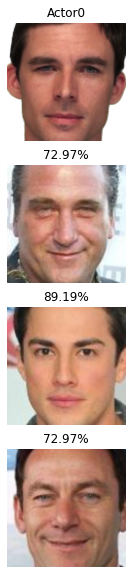

In [131]:
im_celeb_1 = kimage.load_img('/content/celeb/celeba/' + str(ind[0][0]).zfill(6) + '.jpg', target_size = (224, 224))
im_celeb_2 = kimage.load_img('/content/celeb/celeba/' + str(ind[0][1]).zfill(6) + '.jpg', target_size = (224, 224))
im_celeb_3 = kimage.load_img('/content/celeb/celeba/' + str(ind[0][2]).zfill(6) + '.jpg', target_size = (224, 224))

fig = plt.figure(figsize = (12, 10))

fig.add_subplot(4, 1, 1)
plt.imshow(im)
plt.axis('off')
plt.title('Actor' + str(example))
fig.add_subplot(4, 1, 2)
plt.imshow(im_celeb_1)
plt.axis('off')
plt.title(str(acc_1) + '%')
fig.add_subplot(4, 1, 3)
plt.imshow(im_celeb_2)
plt.axis('off')
plt.title(str(acc_2) + '%')
fig.add_subplot(4, 1, 4)
plt.imshow(im_celeb_3)
plt.axis('off')
plt.title(str(acc_3) + '%')

In [ ]:
# Print results
root = tk.Tk()

# Root window title and dimension
root.title("Face retrieval")

canvas1 = tk.Canvas(root, width=400, height=300, relief='raised')
canvas1.pack()

# Display images with accuracy as caption, like in the cell above
'''
label1 = tk.Label(root, text=f'Video prediction:\t{emotions[pred_video.argmax()]}')
label2 = tk.Label(root, text=f'Audio prediction:\t{emotions[pred_audio.argmax()]}')
label3 = tk.Label(root, text=f'Global prediction:\t{emotions[pred_global.argmax()]}')
label4 = tk.Label(root, text=f'Ground truth:\t{emotions[label]}')

label1.config(font=('helvetica', 14))
label2.config(font=('helvetica', 14))
label3.config(font=('helvetica', 14))
label4.config(font=('helvetica', 14), fg='gray')

canvas1.create_window(20, 25, window=label1, anchor='w')
canvas1.create_window(20, 50, window=label2, anchor='w')
canvas1.create_window(20, 75, window=label3, anchor='w')
canvas1.create_window(20, 120, window=label4, anchor='w')
'''

button1 = tk.Button(text='Close', command=lambda: root.destroy(), font=('helvetica', 12, 'bold'))
canvas1.create_window(200, 200, window=button1)

root.mainloop()